In [1]:
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
import argon.numpy as npx
import argon.random
# Define the cost matrix and marginals

n = 100
m = 100

# Sample 100 points from a 2D box for source distribution
mu_samples = 2 * argon.random.uniform(argon.random.key(42), (n, 2)) - 1

# Sample 100 points from a circle for target distribution
nu_samples = argon.random.normal(argon.random.key(43), (m, 2))
nu_samples = nu_samples / npx.linalg.norm(nu_samples, axis=1, keepdims=True)

# Compute the cost matrix
C = npx.sqrt(npx.sum(npx.square(mu_samples[:, None, :] - nu_samples[None, :, :]), -1))

# Compute the marginals -- random draws from [0,1] normalized to sum to 1

mu = argon.random.uniform(argon.random.key(44), n)
mu /= npx.sum(mu)
nu = argon.random.uniform(argon.random.key(45), m)
nu /= npx.sum(nu)

# Box constraints are of form mu_min = 1/a * mu, mu_max = a * mu for a >= 1
# If a = 1, then mu_min = mu_max = mu and we recover the original Sinkhorn problem

a = 2

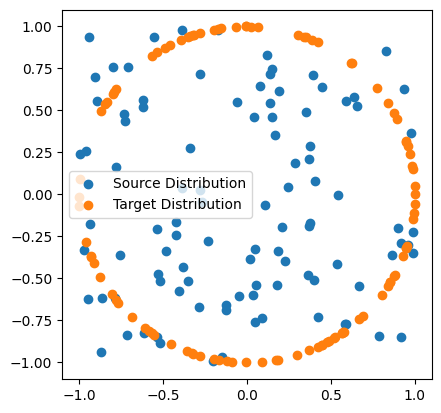

In [3]:
import matplotlib.pyplot as plt

plt.scatter(mu_samples[:, 0], mu_samples[:, 1], label="Source Distribution")
plt.scatter(nu_samples[:, 0], nu_samples[:, 1], label="Target Distribution")
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

Ground truth cost:  0.24406739193010646


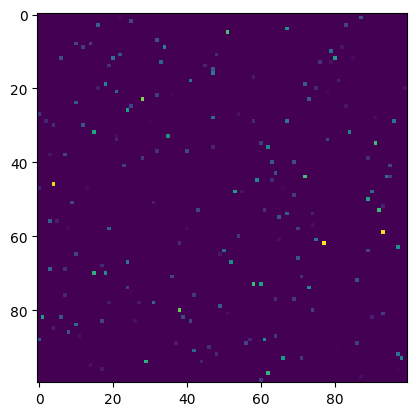

In [4]:
import cvxpy as cp

def relaxed_cvxpy(C, p1, p2, relaxation_factor, epsilon=1e-5):
    M = cp.Variable(C.shape)
    cost = cp.sum(cp.multiply(M, C))
    entropy = cp.sum(cp.entr(M))
    problem = cp.Problem(
        cp.Minimize(cost - epsilon * entropy),
        [
            p1/relaxation_factor <= cp.sum(M, axis=1),
            cp.sum(M, axis=1) <= p1*relaxation_factor,
            p2/relaxation_factor <= cp.sum(M, axis=0),
            cp.sum(M, axis=0) <= p2*relaxation_factor,
            M >= 0, cp.sum(M) == 1,
        ]
    )
    problem.solve(solver=cp.CLARABEL)
    return npx.array(cost.value), npx.array(M.value)

gt_cost, gt_plan = relaxed_cvxpy(C, mu, nu, 1.5, epsilon=1e-5)
print("Ground truth cost: ", gt_cost)
plt.imshow(gt_plan)
plt.show()


Our cost:  nan


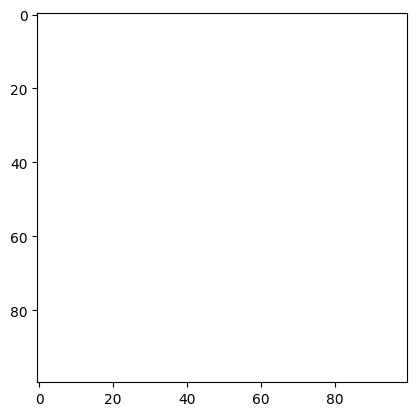

In [9]:
import argon.ott.dykstra as dykstra
solver = dykstra.RelaxedDykstra(
    relaxation_factor=2.,
    max_iterations=1000,
    epsilon=1e-3, tolerance=1e-5,
    enforce_total_mass=True
)
cost, plan = solver.solve(C, mu, nu)
print("Our cost: ", cost)
plt.imshow(plan)
plt.show()